In [1]:
import numpy as np
from scipy import ndimage, sparse
from scipy.linalg import eigh, inv, logm, norm
import sys
import glob
import umap
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


In [2]:
# FROM DATA MATRICES X-XY_data.npz TO UMAP GRAPHS
filename = '/home/garner1/Work/dataset/tissue2graph/ID2_data_RC-XY-A-I'
ID = 'ID2' #patient ID

data = np.load(filename+'.npz',allow_pickle=True)
XY = data['XY'] # spatial coordinates of the nuclei
A = data['A'] # area of the nuclei
I = data['I'] # intensity of the nuclei

In [3]:
nn = int(np.log2(XY.shape[0])) #scale the nn logarithmically in the numb of nodes to have enough density of edges for clustering
print('UMAP with nn='+str(nn))
mat_XY = umap.umap_.fuzzy_simplicial_set(
        XY,
        n_neighbors=nn, 
        random_state=np.random.RandomState(seed=42),
        metric='l2',
        metric_kwds={},
        knn_indices=None,
        knn_dists=None,
        angular=False,
        set_op_mix_ratio=1.0,
        local_connectivity=2.0,
        verbose=False
    )
sparse.save_npz(str(ID)+'_nn'+str(nn)+'.npz',mat_XY)

UMAP with nn=20


In [18]:
# Plot the graph
pos = XY
G = nx.from_scipy_sparse_matrix(mat_XY)

eset = [(u, v) for (u, v, d) in G.edges(data=True)]
weights = [d['weight'] for (u, v, d) in G.edges(data=True)]

sns.set(style='white', rc={'figure.figsize':(50,50)})
nx.draw_networkx_nodes(G, pos, alpha=0.0)
nx.draw_networkx_edges(G, pos, edgelist=eset,alpha=1.0, width=weights,edge_color='r',style='solid')

print('saving graph')
plt.axis('off')
plt.savefig("test.png") # save as png
plt.close()

saving graph


# Stochastic walk on the graph of nuclei

* Given the spatial matrix of connections, we normalize it so that all rows sum to 1; let's call S the row-stochastic matrix.
* Applying S to the col-vector of nuclei's areas we obtain the vector whose i-th row represent the average area of the nuclei at 1 step from the i-th nucleus in the graph, weighted by the probability of the random walker going from i to each of the neighbor nuclei
* Applying S n-times gives a col-vector whose i-th row represent the average area of the nuclei at n-step from the i-th nucleus in the graph, weighted by the probability of the random walker going from i to each of the n-neighboring nuclei 

The path-averaged area 1-step starting from $i$ is $\sum_jS_i^j a_j^1$. In general the path-averaged area n-steps starting from $i$ is $S^n a = \sum_{\cdots j}S_i^{(1)\cdot} ... S_{\cdot}^{(n)j} a_j^1$$

The path-average distribution of both area and intensity's density are well aproximated by a log-normal and by a normal distribution, respectively. Hence we could use the absolute value of the z-score to determine a node attribute and color the graph nodes based on this attibute.

In [5]:
mat_XY = sparse.load_npz('/home/garner1/Work/pipelines/graviti/py/ID2_nn20.npz')

In [6]:
from sklearn.preprocessing import normalize

S = normalize(mat_XY, norm='l1', axis=1) #normalized by row

0
1
2
3
4
5
6
7
8


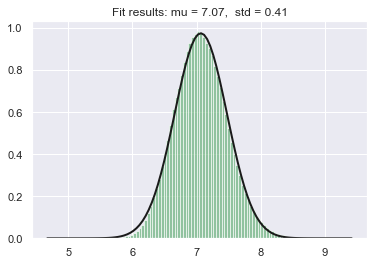

In [37]:
vec = A #np.divide(I,A)
history = vec
nn = 9
for counter in range(nn):
    print(counter)
    vec = S.dot(vec)
    history = np.hstack((history,vec)) 

import numpy as np
from scipy.stats import norm, zscore, poisson
import matplotlib.pyplot as plt

# Fit a normal distribution to the data:
step = counter
mu, std = norm.fit(np.log2(history[:,step])) # you could also fit to a lognorma the original data
plt.hist(np.log2(history[:,step]), bins=100, density=True, alpha=0.6, color='g')
                       
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

0
1
2
3
4
5
6
7
8
9


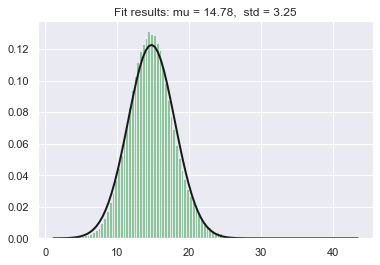

In [49]:
vec = np.divide(I,A)
history = vec
nn = 10
for counter in range(nn):
    print(counter)
    vec = S.dot(vec)
    history = np.hstack((history,vec)) 

import numpy as np
from scipy.stats import norm, zscore, poisson
import matplotlib.pyplot as plt

# Fit a normal distribution to the data:
step = counter
mu, std = norm.fit(history[:,step]) # you could also fit to a lognorma the original data
plt.hist(history[:,step], bins=100, density=True, alpha=0.6, color='g')
                       
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

(array([8.0594e+04, 7.9517e+04, 7.8073e+04, 7.7321e+04, 7.6409e+04,
        7.4247e+04, 7.2484e+04, 6.9432e+04, 6.5923e+04, 6.2605e+04,
        5.8849e+04, 5.4891e+04, 5.1107e+04, 4.7638e+04, 4.3953e+04,
        3.9691e+04, 3.6769e+04, 3.2947e+04, 3.0423e+04, 2.7609e+04,
        2.4518e+04, 2.2199e+04, 2.0248e+04, 1.8114e+04, 1.6139e+04,
        1.4195e+04, 1.2394e+04, 1.0730e+04, 9.2480e+03, 8.3210e+03,
        7.2650e+03, 6.4560e+03, 5.5140e+03, 4.7070e+03, 4.0460e+03,
        3.4140e+03, 3.0340e+03, 2.7190e+03, 2.2260e+03, 1.9610e+03,
        1.5240e+03, 1.3420e+03, 1.2100e+03, 1.0750e+03, 9.6300e+02,
        8.3900e+02, 8.6200e+02, 7.8500e+02, 7.1400e+02, 6.3100e+02,
        6.4900e+02, 5.4400e+02, 4.4700e+02, 4.2900e+02, 4.0200e+02,
        3.7500e+02, 3.4200e+02, 3.2000e+02, 2.7800e+02, 2.7600e+02,
        2.4300e+02, 2.4200e+02, 2.7000e+02, 2.3000e+02, 2.0500e+02,
        1.8600e+02, 1.7900e+02, 1.4100e+02, 1.6200e+02, 1.3700e+02,
        1.4200e+02, 1.2500e+02, 1.1800e+02, 1.17

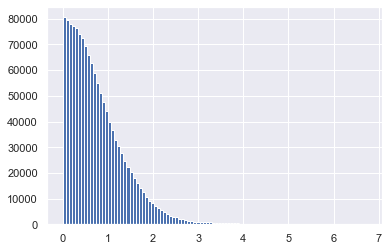

In [50]:
plt.hist(abs(zscore(np.log2(history[:,step]))),bins=100)

In [ ]:
z = abs(zscore(np.log2(history[:,step]))) # this becomes a node attribute: color the node based on this